# Persistence

## Simplex def

In [1]:
class Simplex:
    def __init__(self, val, dim, vert):
        self.val = val
        self.dim = dim
        self.vert = vert
        
    def __eq__(self, simplex2):
        return self.vetices.__eq__(simplex2.verticles)
    

    def toString(self):
        return "val = {}; dim = {}; vert = {}".format(self.val, self.dim, "/".join(self.vert))

## Load the data

In [2]:
simplex_list = []

with open("filtrations/test_filtration2.txt", "r") as test_filtration:
    for line in test_filtration.readlines():        
        inputs = line.strip().split(" ")
        f, dim = float(inputs[0]), int(inputs[1])
        vertices = sorted(list(map(int, inputs[2:]))) # vertices are sorted so we can compare between list of vertices
        simplex_list.append(Simplex(f, dim, vertices))
        
simplex_list = sorted(simplex_list, key=lambda x:(x.val, x.dim)) # sort according to val and then to dim (to have a simplicial complex)


dic_simplex = {} # maps a simplex (as a sorted tuple of vertices) to its indentifier 
for i, s in enumerate(simplex_list):
    dic_simplex[tuple(s.vert)] = i
        

FileNotFoundError: [Errno 2] No such file or directory: 'filtrations/test_filtration2.txt'

## Boundary matrix

In [3]:
def compute_boundary(simplex, dic_simplex):
    """return the identifiers of the boundaries of the simplex"""
    boundaries_id = []
    for i in range(simplex.dim + 1):
        new_vert = list(simplex.vert)
        del new_vert[i]
        if len(new_vert) > 0:
            boundaries_id.append(dic_simplex[tuple(sorted(new_vert))]) # new_vert must be sorted because we compare tuple (it's actually already sorted but we sort it for code clarity)
    return boundaries_id
        

In [4]:
# We define low(i) = the maximal non-zero element for the i-th simplex.

# dic_low[k] = list containing all the simplices i whose low(i) is in the k-th row, i.e. corresponds to the k-th simplex
# dic_boundaries[i] = list containing all the non-zero boundary simplices from the i-th simplex
dic_low, dic_boundaries = {},{} 
for i in range(len(simplex_list)):
    dic_boundaries[i] = [] # initialization
    dic_low[i] = []

for simplex in simplex_list:
    
    simplex_vert = tuple(sorted(simplex.vert))
    simplex_coord = dic_simplex[simplex_vert] #identifier of the simplex
    boundaries_id = compute_boundary(simplex, dic_simplex)
    if len(boundaries_id) > 0:
        dic_boundaries[simplex_coord] = boundaries_id
        low_i = max(boundaries_id)
        # Check if they're already another simplex with the same low(i)
        dic_low[low_i] = dic_low[low_i] + [simplex_coord] if (low_i in dic_low.keys()) else [simplex_coord] 
    for boundary_id in boundaries_id:
         #identifier of the boundary simplex
        dic_coord[(simplex_coord, boundary_id)] = 1
        


In [5]:
dic_boundaries

{}

## Reduction

In [6]:
def sum_boundaries(boundaries1, boundaries2):
    """sum the list of boundaries of 2 simplex in Z/2Z
    Complexity could be improved"""
    res = []
    for b in boundaries1:
        if b not in boundaries2:
            res.append(b)
    for b in boundaries2:
        if b not in res and b not in boundaries1:
            res.append(b)
    return res
        

def gaussian_elim(dic_low, dic_boundaries):
    pivots = []
    for i in reversed(range(0, len(dic_boundaries.keys()))):
        if i in dic_low.keys():
            columns = sorted(dic_low[i])
            if len(columns) > 0:  # if there are columns to kill
                pivot_column = columns[0]
                pivots.append(pivot_column)
                for column in columns[1:]:
                    # sum in Z/2Z
                    dic_boundaries[column] = sum_boundaries(dic_boundaries[column], dic_boundaries[pivot_column])
                    if len(dic_boundaries[column]) > 0: 
                        # update the pivot
                        new_pivot = max(dic_boundaries[column])
                        if new_pivot in dic_low.keys():
                            dic_low[new_pivot].append(column)
                        else:
                            dic_low[new_pivot] = [column]
                            
    return pivots, dic_boundaries
            
pivots, dic_boundaries = gaussian_elim(dic_low, dic_boundaries)

In [7]:
dic_boundaries

{}

## Bar code

In [8]:
def bar_codes(simplex_list, dic_boundaries):
    threshold = 0.05

    bar_codes = {}
    for i, s in enumerate(simplex_list):
        if len(dic_boundaries[i]) == 0: #create a cycle
            bar_codes[i] = None
        else: #kill a cycle (create a boundary)
            k = max(dic_boundaries[i]) # pivot
            if k in bar_codes.keys():
                bar_codes[k] = i

    for s1_id in bar_codes.keys():
        dim = simplex_list[s1_id].dim
        s2_id = bar_codes[s1_id]
        s1_val = simplex_list[s1_id].val
        if s2_id: # the cycle as been killed
            s2_val = simplex_list[s2_id].val
            if s2_val - s1_val > threshold:
                print(dim, s1_val, s2_val)
        else: # the cycle has never been killed
            s2_val = "inf"
            print(dim, s1_val, s2_val)
        
bar_codes(simplex_list, dic_boundaries)

In [101]:
import itertools as itertools

def top_simplices_from_figure(list_vertices):
    # Useful function to list the top-dimensional subsimplices from the Moebius band, the torus and the Klein bottle.
    """
    Input: 2D-list from the vertices, row by row
    Output: set from the top-dimensional simplices (here the 2D simplices), i.e. set of list of vertices
    """
    top_simplices = [] 
    for i in range(len(list_vertices) - 1):
        for j in range(len(list_vertices[i]) - 1):
            top_simplices.append((list_vertices[i][j],list_vertices[i][j+1],list_vertices[i+1][j]))
            top_simplices.append((list_vertices[i][j+1],list_vertices[i+1][j],list_vertices[i+1][j+1]))
    return set(top_simplices)

def subsimplices_from_simplex(simplex_vert):
    """
    Input: tuple from the vertices of the simplex
    Output: set from the subsimplices, i.e. set of tuple of vertices. Includes the input simplex.
    """
    return set(itertools.chain(*[itertools.combinations(simplex_vert, dim) for dim in range(1,len(simplex_vert) + 1)]))

def all_simplices_from_top_simplices(simplices_set):
    """
    Input: set from the simplices, i.e. set of tuples of vertices
    Output: list from the simplices sorted in crescent order for the dimension and for the name
    """
    all_simplices = simplices_set.copy()
    for simplex_vert in simplices_set:
        new_simplices = subsimplices_from_simplex(simplex_vert)
        for new_simplex in new_simplices:
            all_simplices.add(new_simplex)
    all_simplices = sorted(list(all_simplices), key = lambda x:(len(x),x[0]))
    return all_simplices

def from_simplices_to_filtration(sorted_simplices_list):
    """
    Input: list from the simplices sorted in crescent order for the dimension and for the name
    Output: filtration = list from the simplices sorted in crescent order for the dimension
    (according to the syntax 
        Time of appearance in the filtration | Dimension | List from the vertices
    )
    In our filtration : 
        Time of appearance(simplex K) = dim(simplex K) 
    """  
    filtration = []
    for ord_simplex in sorted_simplices_list:
        new_filtration = str(len(ord_simplex)-1) + str(' ') + str(len(ord_simplex)-1) + str(' ') + "".join(str(ord_simplex[i]) + str(' ') for i in range(len(ord_simplex)))
        filtration.append(new_filtration)
    return filtration
    
def compute_filtrations(d):
    # Compute all the required filtrations
    """
    Input: wanted dimension for the d-ball and for the d-sphere
    Output: list with all the required filtrations, according to the syntax given in "from simplices to filtration"
    """
    all_filtrations = []
    
    # For the d-ball
    all_filtrations.append(from_simplices_to_filtration(all_simplices_from_top_simplices(subsimplices_from_simplex(top_simplex_d_ball(d)))))
    
    # For the d-sphere    
    all_filtrations.append(from_simplices_to_filtration(all_simplices_from_top_simplices(subsimplices_from_simplex(top_simplex_d_ball(d))))[:-1]) # We remove the (d+1) simplex

    # For the Moebius band
    all_filtrations.append(from_simplices_to_filtration(all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_Moebius_band()))))
    
    # For the torus
    all_filtrations.append(from_simplices_to_filtration(all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_torus()))))
    
    # For the Klein bottle
    all_filtrations.append(from_simplices_to_filtration(all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_Klein_bottle()))))

    # For the projective plane
    all_filtrations.append(from_simplices_to_filtration(all_simplices_from_top_simplices(top_simplices_projective_plane())))
    
    return all_filtrations
    
def triangulation_Moebius_band():
    """
    Output: 2D-list from the vertices, row by row, corresponding to a triangulation from the Moebius band
    """
    return [['A','B','C','D'],['D','E','F','A']]

def triangulation_torus():
    """
    Output: 2D-list from the vertices, row by row, corresponding to a triangulation from the torus
    """
    return [['A','B','C','A'],['D','E','F','D'],['G','H','I','G'],['A','B','C','A']]

def triangulation_Klein_bottle():
    """
    Output: 2D-list from the vertices, row by row, corresponding to a triangulation from the Klein bottle
    """
    return [['A','B','C','A'],['D','E','F','G'],['G','H','I','D'],['A','B','C','A']]

def top_simplices_projective_plane():
    """
    Output: set from the top-dimensional simplices (here the 2D simplices from a triangulation from the 2D projective plane), i.e. set of list of vertices
    """
    return set([('A','B','D'),('B','C','D'),('C','D','E'),('C','E','A'),('A','E','B'),('B','E','F'),('B','C','F'),('A','F','C'),('A','F','D'),('D','E','F')])

def top_simplex_d_ball(d):
    """
    Input: the dimension d
    Output: tuple of the (d+1) vertices from the top-dimensional simplex of the d-ball
    """
    assert d < 11 # We could have gone further, one can easily modify it by extending list_max_vertices
    list_vertices = ['A','B','C','D','E','F','G','H','I','J','K']
    return tuple(list_vertices[:d+1])


# For practical reasons for the drawing of the filtration, 
# we define another triangulation for the Moebius band, the torus, the Klein bottle
# as the same vertices appear several times

def triangulation_Moebius_band_for_drawing():
    """
    Output: 2D-list from the vertices, row by row, corresponding to a triangulation from the Moebius band
    """
    return [['A1','B','C','D1'],['D2','E','F','A2']]

def triangulation_torus_for_drawing():
    """
    Output: 2D-list from the vertices, row by row, corresponding to a triangulation from the torus where we 'split' each vertex.
    """
    return [['A1','B1','C1','A2'],['D1','E','F','D2'],['G1','H','I','G2'],['A3','B2','C2','A4']]

def triangulation_Klein_bottle_for_drawing():
    """
    Output: 2D-list from the vertices, row by row, corresponding to a triangulation from the Klein bottle
    """
    return [['A1','B1','C1','A2'],['D1','E','F','G1'],['G2','H','I','D2'],['A3','B2','C2','A4']]

def compute_all_simplices_for_drawing(d):
    """
    Input: wanted dimension for the d-ball and for the d-sphere
    Output: list with all the required simplicial complexes with splitted vertices
    """
    all_filtrations = []
    
    # For the d-ball
    all_filtrations.append(all_simplices_from_top_simplices(subsimplices_from_simplex(top_simplex_d_ball(d))))
    
    # For the d-sphere    
    all_filtrations.append(all_simplices_from_top_simplices(subsimplices_from_simplex(top_simplex_d_ball(d)))[:-1]) # We remove the (d+1) simplex

    # For the Moebius band
    all_filtrations.append(all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_Moebius_band_for_drawing())))
    
    # For the torus
    all_filtrations.append(all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_torus_for_drawing())))
    
    # For the Klein bottle
    all_filtrations.append(all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_Klein_bottle_for_drawing())))

    # For the projective plane
    all_filtrations.append(all_simplices_from_top_simplices(top_simplices_projective_plane()))
    
    return all_filtrations

In [64]:
compute_filtrations_for_drawing(3)

[[('A',),
  ('B',),
  ('C',),
  ('D',),
  ('A', 'C'),
  ('A', 'B'),
  ('A', 'D'),
  ('B', 'D'),
  ('B', 'C'),
  ('C', 'D'),
  ('A', 'B', 'D'),
  ('A', 'C', 'D'),
  ('A', 'B', 'C'),
  ('B', 'C', 'D'),
  ('A', 'B', 'C', 'D')],
 [('A',),
  ('B',),
  ('C',),
  ('D',),
  ('A', 'C'),
  ('A', 'B'),
  ('A', 'D'),
  ('B', 'D'),
  ('B', 'C'),
  ('C', 'D'),
  ('A', 'B', 'D'),
  ('A', 'C', 'D'),
  ('A', 'B', 'C'),
  ('B', 'C', 'D')],
 [('A1',),
  ('A2',),
  ('B',),
  ('C',),
  ('D1',),
  ('D2',),
  ('E',),
  ('F',),
  ('A1', 'D2'),
  ('A1', 'B'),
  ('B', 'C'),
  ('B', 'E'),
  ('B', 'D2'),
  ('C', 'D1'),
  ('C', 'E'),
  ('C', 'F'),
  ('D1', 'F'),
  ('D1', 'A2'),
  ('D2', 'E'),
  ('E', 'F'),
  ('F', 'A2'),
  ('A1', 'B', 'D2'),
  ('B', 'C', 'E'),
  ('B', 'D2', 'E'),
  ('C', 'D1', 'F'),
  ('C', 'E', 'F'),
  ('D1', 'F', 'A2')],
 [('A1',),
  ('A2',),
  ('A3',),
  ('A4',),
  ('B1',),
  ('B2',),
  ('C1',),
  ('C2',),
  ('D1',),
  ('D2',),
  ('E',),
  ('F',),
  ('G1',),
  ('H',),
  ('I',),
  ('A1', 'D1'),


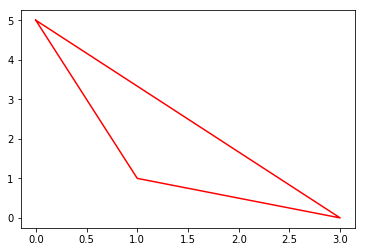

In [19]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

polygon1 = Polygon([(0,5), (1,1), (3,0)])

plt.plot(*polygon1.exterior.xy,c='r');

In [25]:
#This set of functions allows for building a Vietoris-Rips simplicial complex from point data

import numpy as np
import matplotlib.pyplot as plt

def euclidianDist(a,b):
    return np.linalg.norm(a - b) #euclidian distance metric

#Build neighorbood graph
def buildGraph(raw_data, epsilon = 3.1, metric=euclidianDist): #raw_data is a numpy array
    nodes = [x for x in range(raw_data.shape[0])] #initialize node set, reference indices from original data array
    edges = [] #initialize empty edge array
    weights = [] #initialize weight array, stores the weight (which in this case is the distance) for each edge
    for i in range(raw_data.shape[0]): #iterate through each data point
        for j in range(raw_data.shape[0]-i): #inner loop to calculate pairwise point distances
            a = raw_data[i]
            b = raw_data[j+i] #each simplex is a set (no order), hence [0,1] = [1,0]; so only store one
            if (i != j+i):
                dist = metric(a,b)
                if dist <= epsilon:
                    edges.append({i,j+i}) #add edge if distance between points is < epsilon
                    weights.append([len(edges)-1,dist]) #store index and weight
    return nodes,edges,weights

def lower_nbrs(nodeSet, edgeSet, node): #lowest neighbors based on arbitrary ordering of simplices
    return {x for x in nodeSet if {x,node} in edgeSet and node > x}

def ripsFiltration(nodes, edges, weights, k): #k is the maximal dimension we want to compute
    VRcomplex = [{n} for n in nodes]
    filter_values = [0 for j in VRcomplex] #vertices have filter value of 0
    for i in range(len(edges)): #add 1-simplices (edges) and associated filter values
        VRcomplex.append(edges[i])
        filter_values.append(weights[i])
    for i in range(k):
        for simplex in [x for x in VRcomplex if len(x)==i+2]: #skip 0-simplices
            #for each u in simplex
            nbrs = set.intersection(*[lower_nbrs(nodes, edges, z) for z in simplex])
            for nbr in nbrs:
                VRcomplex.append(set.union(simplex,{nbr}))
    return VRcomplex, filter_values

def getFilterValue(simplex, complex, filter_values):
    return filter_values[complex.index(simplex)]

def drawComplex(origData, ripsComplex, axes=[-6,8,-6,6]):
    plt.clf()
    plt.axis(axes)
    plt.scatter(origData[:,0],origData[:,1]) #plotting just for clarity
    for i, txt in enumerate(origData):
        plt.annotate(i, (origData[i][0]+0.05, origData[i][1])) #add labels

    #add lines for edges
    for edge in [e for e in ripsComplex if len(e)==2]:
      #print(edge)
      pt1,pt2 = [origData[pt] for pt in [n for n in edge]]
      #plt.gca().add_line(plt.Line2D(pt1,pt2))
      line = plt.Polygon([pt1,pt2], closed=None, fill=None, edgecolor='r')
      plt.gca().add_line(line)

    #add triangles
    for triangle in [t for t in ripsComplex if len(t)==3]:
        pt1,pt2,pt3 = [origData[pt] for pt in [n for n in triangle]]
        line = plt.Polygon([pt1,pt2,pt3], closed=False, color="blue",alpha=0.3, fill=True, edgecolor=None)
        plt.gca().add_line(line)
    plt.show()

In [109]:
import pandas as pd

# We provide a drawing for our filtrations (with dim of d-ball / d-sphere <= 3)

def representation_all(d):
    """
    Input: wanted dimension for the d-ball and for the d-sphere. d has to be < 4.
    Output: a figure for each filtration
    """
    
    
# We compute the coordinates of the vertices from the Moebius band, the torus and the Klein bottle in a unified way   
def assign_coordinates(list_vertices):
    """
    Input: 2D-list from the vertices, row by row
    Output: vertices_id = [name from vertices_coord[i] for i in range(len(vertices_coord))], vertices_coord = [[coord[vertex_i]] for i in input_list]
    """
    len_row = len(list_vertices[0])    
    vertices_id = []
    vertices_coord = []
    for y_coord in range(len(list_vertices)):
        for x_coord in range(len_row):
            vertices_id.append(list_vertices[y_coord][x_coord],)
            vertices_coord.append([x_coord,y_coord])
    return vertices_id,vertices_coord

def draw_filtration(vertices_id,vertices_coord,list_all_simplices,axes=[-1,4,-1,4]):
    # To be improved. Inspired from OpenTDA.
    plt.clf()
    plt.axis(axes)
    plt.scatter([x[0] for x in vertices_coord],[x[1] for x in vertices_coord])
    for i,txt in enumerate(vertices_coord):
        plt.annotate(vertices_id[i], (vertices_coord[i][0]+0.05, vertices_coord[i][1])) #add labels        

    #add lines for edges
    for edge in [e for e in list_all_simplices if len(e)==2]:
      #print(edge)
      pt1,pt2 = [vertices_coord[vertices_id.index(pt)] for pt in [n for n in edge]]
      #plt.gca().add_line(plt.Line2D(pt1,pt2))
      line = plt.Polygon([pt1,pt2], closed=None, fill=None, edgecolor='r')
      plt.gca().add_line(line)

    #add triangles
    for triangle in [t for t in list_all_simplices if len(t)==3]:
        pt1,pt2,pt3 = [vertices_coord[vertices_id.index(pt)] for pt in [n for n in triangle]]
        line = plt.Polygon([pt1,pt2,pt3], closed=False, color="y",alpha=0.3, fill=True, edgecolor=None)
        plt.gca().add_line(line)
    plt.show()

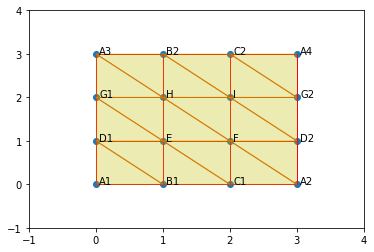

In [107]:
draw_filtration(v_id,v_coord,all_simplices_from_top_simplices(top_simplices_from_figure(triangulation_torus_for_drawing())))